In [64]:
import numpy as np
from matplotlib import pyplot as plt

In [65]:
def get_dist(p1, p2):
    '''Calculate the Euclidean measure
    p1,p2 are three-element lists
    '''
    # TODO: implement linalg approach (i.e. dot product / det?)
    return np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2 + (p2[2]-p1[2])**2)

# return the homogenous form of vector x
# vector x must be series of 3D vectors
def h(x):
    if len(np.shape(x)) == 2 and np.shape(x)[0] == 3:
        return np.vstack([x, np.ones(np.shape(x)[1])])
    else:
        raise ValueError("Input to homogenous function must be series of 3D vectors")
    
# return the Euclidean form of homogenous vector h
# homogenous vector h must be series of 4D vectors
def f(h):
    if len(np.shape(h)) == 2 and np.shape(h)[0] == 4:
        return h[0:3,:]
    else:
        raise ValueError("Input to homogenous function must be series of 2D vectors")

In [66]:
# define 3D rotation matrices about each Euler angle
def get_Rx(theta, unit="rad"):
    if unit == "deg":
        theta *= np.pi/180
    elif unit == "rad":
        pass
    else:
        raise ValueError("Unit must be 'deg' or 'rad'.")
    
    return np.array([[1,             0,              0, 0],
                     [0, np.cos(theta), -np.sin(theta), 0],
                     [0, np.sin(theta),  np.cos(theta), 0],
                     [0,             0,              0, 1]
                   ])

def get_Ry(theta, unit="rad"):
    if unit == "deg":
        theta *= np.pi/180
    elif unit == "rad":
        pass
    else:
        raise ValueError("Unit must be 'deg' or 'rad'.")
    
    return np.array([[ np.cos(theta), 0, np.sin(theta), 0],
                     [             0, 1,             0, 0],
                     [-np.sin(theta), 0, np.cos(theta), 0],
                     [             0, 0,             0, 1]
                   ])

def get_Rz(theta, unit="rad"):
    if unit == "deg":
        theta *= np.pi/180
    elif unit == "rad":
        pass
    else:
        raise ValueError("Unit must be 'deg' or 'rad'.")
    
    return np.array([[np.cos(theta), -np.sin(theta), 0, 0],
                     [np.sin(theta),  np.cos(theta), 0, 0],
                     [            0,              0, 1, 0],
                     [            0,              0, 0, 1]
                   ])

def get_T(delta_x, delta_y, delta_z):
    return np.array([[1, 0, 0, delta_x],
                     [0, 1, 0, delta_y],
                     [0, 0, 1, delta_z],
                     [0, 0, 0, 1]
                   ])



In [67]:
# # confirm transformation functions
# print(get_Rx(30,"deg"))
# print(get_T(1,2,3))

In [68]:
class Mesh:
    def __init__(self, pts_x, pts_y, pts_z, nds_x=None, nds_y=None, nds_z=None):
        # define arbitrary off-axis rotation to ensure delta for interpolation.
        # must not be multiple of 90-deg
        self.alpha = 30     # rotation about X
        self.beta = 30      # rotation about Y
        self.gamma = 30     # rotation about Z
        self.unit = "deg"

        # read in datums
        if len(pts_x) == len(pts_y) == len(pts_z):
            self.num_pts = len(pts_x)
            self.pts_x = pts_x
            self.pts_y = pts_y
            self.pts_z = pts_z
            self.update_datums()
        else:
            raise ValueError("Length of pts_x and pts_y must be the same.")
        
        # read in nodes if defined (i.e. for template mesh)
        if nds_x and nds_y and nds_z:
            if len(nds_x) == len(nds_y) == len(nds_z):
                self.num_nds = len(nds_x)
                self.nds_x = nds_x
                self.nds_y = nds_y
                self.nds_z = nds_z
                self.update_nodes()
                
                # declare and fill mesh nodal references
                self.nd_r = np.ones([self.num_nds,3])       # scaling parameter associated with each node
                self.nd_dats = np.ones([self.num_nds,2])    # reference datum associated with each node
                self.fill_nd_info()
            else:
                raise ValueError("Length of nds_x and nds_y must be the same.")
        # declare nodes if not defined
        elif not (nds_x or nds_y or nds_z):
            self.num_nds = 0
            self.nds_x = None
            self.nds_y = None
            self.nodes = None
        else:
            raise ValueError("Incomplete input. Must pass all nds_x, nds_y, and nds_z if used.")
    
    def update_datums(self):
        self.datums = np.array([self.pts_x, self.pts_y, self.pts_z])

    def update_nodes(self):
        self.nodes = np.array([self.nds_x, self.nds_y, self.nds_z])

    def plot_mesh(self, show_nodes=False):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(xs=self.pts_x, ys=self.pts_y, zs=self.pts_z, s=50, marker='o')
        if show_nodes:
            ax.scatter(xs=self.nds_x, ys=self.nds_y, zs=self.nds_z, s=10, marker='D')
        
        ax.set_xlabel("X-Axis")
        ax.set_ylabel("Y-Axis")
        ax.set_zlabel("Z-Axis")
        plt.show()

    def get_closest_datums(self, nd):
        '''find two closest datums to specified nd'''
        min_dist = np.inf
        pen_dist = np.inf
        min_pt = None       # datum with minimum distance
        pen_pt = None       # datum with second minimum distance (penultimate)
        for pt in range(self.num_pts):
            pt_dist = get_dist(self.nodes[:,nd], self.datums[:,pt])
            if pen_pt is None:
                if pt_dist < min_dist:
                    min_dist = pt_dist
                    min_pt = pt
                    pen_pt = pt

            elif pt_dist < pen_dist:    
                if pt_dist < min_dist:
                    pen_dist = min_dist
                    pen_pt = min_pt
                    min_dist = pt_dist
                    min_pt = pt
                else:   
                    pen_dist = pt_dist
                    pen_pt = pt

        return min_pt, pen_pt
    
    def get_transform_mat(self, dat, alpha, beta, gamma, unit="rad"):
        '''get transformation matrix relating off-axis coordinate system to global'''
        Tm = get_T(-self.pts_x[dat], -self.pts_y[dat], -self.pts_z[dat])
        Rx = get_Rx(alpha, unit)
        Ry = get_Ry(beta, unit)
        Rz = get_Rz(gamma, unit)

        return np.matmul(Rz, np.matmul(Ry, np.matmul(Rx, Tm)))
    
    def transform_coords(self, Tm, v):
        return f(np.matmul(Tm, h(v)))

    def get_r(self, B, N, A=None):
        '''calculate scaling constant, r, for node interpolation, i.e. solve B = A + (1/r)N
        where: A, B, N are position vectors. Note, in transformed off-axis CS, A = O
        '''
        if type(A) == np.ndarray and A.any():
            raise ValueError("Currently only have capability to solve scaling constant for A=0. Use transform CS.")
        
        elif A is None:
            return np.divide(N,B)
        
        else:
            raise ValueError("A should be np.ndarray or None")
    
    def fill_nd_info(self):
        '''save data defining node interpolation for each node location
        
        note, this method applicable to template/original mesh
        '''
        for nd in range(self.num_nds):
            # find reference datums for nodal interpolation
            dat1, dat2 = self.get_closest_datums(nd)

            # get position vectors, note A defined as O in ref frame
            B = self.datums[:,dat2].reshape((3,1))
            N = self.nodes[:,nd].reshape((3,1))

            # transform coords into ref frame
            Tm = self.get_transform_mat(int(dat1), self.alpha, self.beta, self.gamma, self.unit)
            B_transform = f(np.matmul(Tm, h(B)))
            N_transform = f(np.matmul(Tm, h(N)))

            # save scaling parameter and reference datums for each node location
            self.nd_r[nd,:] = self.get_r(B_transform, N_transform).ravel()
            self.nd_dats[nd,:] = [dat1, dat2]

    def get_curvature(self):
        '''project nodes onto linear path, i.e. solve O + sB = N + tv'''

        pass
    
    def gen_mesh(self, orig_mesh):
        self.num_nds = orig_mesh.num_nds
        self.nodes = np.ones([3,self.num_nds])
    
        for nd in range(self.num_nds):
            # extract node info from template mesh
            ru, rv, rw = orig_mesh.nd_r[nd,:]
            dat1, dat2 = orig_mesh.nd_dats[nd,:]
            img_B = self.datums[:,int(dat2)].reshape((3,1))

            # recalc transformation to account for moving ref-frame, transform coords
            Tm = self.get_transform_mat(int(dat1), self.alpha, self.beta, self.gamma, self.unit)
            img_B_transform = f(np.matmul(Tm, h(img_B)))

            # perform node interpolation in ref frame (defined as B = (1/r)N).
            img_N_transform = np.array([[img_B_transform[0,0]*ru],
                                        [img_B_transform[1,0]*rv],
                                        [img_B_transform[2,0]*rw]
                                      ])

            # perform inverse transformation to obtain global node positions
            img_N = f(np.matmul(np.linalg.inv(Tm), h(img_N_transform)))
            self.nodes[:,nd] = img_N.ravel()
        
        # populate bases
        self.nds_x = self.nodes[0,:].ravel()
        self.nds_y = self.nodes[1,:].ravel()
        self.nds_z = self.nodes[2,:].ravel()

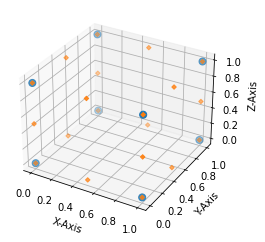

[[1]
 [0]
 [0]]


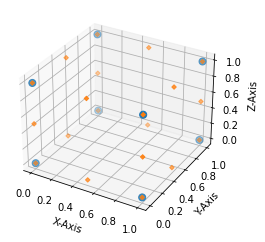

In [ ]:
pts_x = [0,1,1,0,0,1,1,0]
pts_y = [0,0,1,1,0,0,1,1]
pts_z = [0,0,0,0,1,1,1,1]

nds_x = [0,0.5,1,1,1,0.5,0,0, 0,1,1,0, 0,0.5,1,1,1,0.5,0,0]
nds_y = [0,0,0,0.5,1,1,1,0.5, 0,0,1,1, 0,0,0,0.5,1,1,1,0.5]
nds_z = [0,0,0,0,0,0,0,0, 0.5,0.5,0.5,0.5, 1,1,1,1,1,1,1,1]

orig_mesh = Mesh(pts_x, pts_y, pts_z, nds_x, nds_y, nds_z)
orig_mesh.plot_mesh(show_nodes=True)

# define image datums
pts_x = [0,1,1,0,0,1,0.5,0]
pts_y = [0,0,1,1,0,0,1,1]
pts_z = [0,0,0,0,1,1,1,1]
img_mesh = Mesh(pts_x, pts_y, pts_z)

print(orig_mesh.datums[:,1].reshape((3,1)))

img_mesh.gen_mesh(orig_mesh)
img_mesh.plot_mesh(show_nodes=True)

